In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

| | |
|----------|-------------|
| Author(s)   | Lei Pan |
| Last updated | 11/01/2023 |

# Code Migration with Code Chat

Codey models are text-to-code models from Google AI, trained on a massive code related dataset. You can generate code related responses for different scenarios such as writing functions, unit tests, debugging, explaining code etc. Here is [the overview](https://cloud.google.com/vertex-ai/docs/generative-ai/code/code-models-overview) of all the Codey APIs.

In this notebook, we will show you how to use code chat API to migrate code from COBOL to JAVA by following the steps below.

- Step 1: COBOL migration with step-by-step instructions
- Step 2: Generate tests for the migrated code
- Step 3: Refactor the migrated code
- Step 4: Document the code migration processes



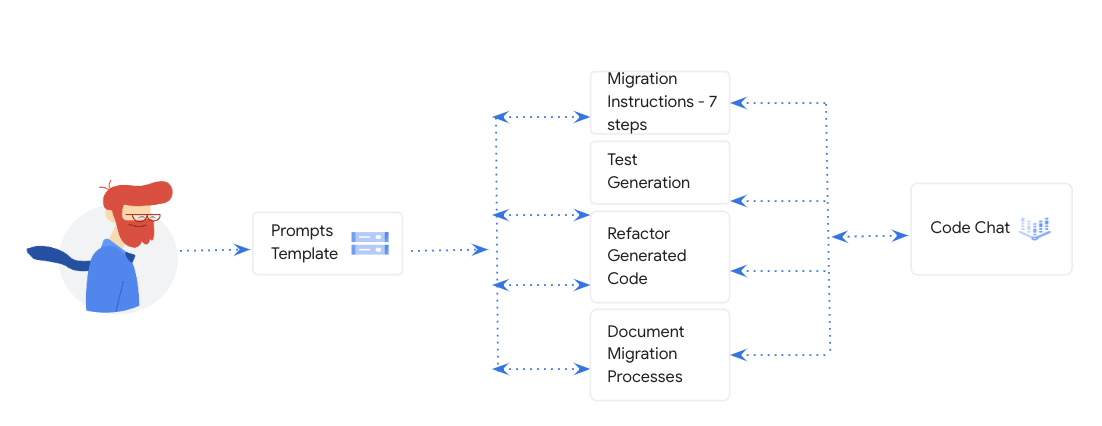

## Prep Work

If you don't have a GCP project set up and Vertex AI enabled, please follow [the doc](https://cloud.google.com/vertex-ai/docs/start/cloud-environment#set_up_a_project) to set them up before you proceed.

### Install Vertex AI SDK, Other Packages and Their Dependencies

Install the following packages required to execute this notebook.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    ! pip install google-cloud-aiplatform
    ! pip install jsonlines
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

In [ ]:
import sys
import json
import os
import vertexai
import pandas as pd
from typing import Dict, List, Optional, Tuple
from google.cloud import discoveryengine
from google.protobuf.json_format import MessageToDict

### Initialize Vertex AI

Please set VERTEX_API_PROJECT and VERTEX_API_LOCATION below with your project id and location for Vertex AI. This should be the project in which you enabled Vertex AI

In [ ]:
import vertexai
from vertexai.preview.language_models import CodeChatModel

VERTEX_API_PROJECT = '<project id>'
VERTEX_API_LOCATION = '<location>'

vertexai.init(project=VERTEX_API_PROJECT, location=VERTEX_API_LOCATION)

### Initialize Code Chat Model

- You can specify the version of the Codey models you want to use. Here is [the list](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/model-versioning)  of all the available models


- You can pass 3 parameters here: prompt, max size of token, and temperature.

In [ ]:
code_chat_model = CodeChatModel.from_pretrained("codechat-bison")
chat = code_chat_model.start_chat()

def send_message(message, max_token=1024):
    parameters = {
    "temperature": 0,
    "max_output_tokens": max_token
    }
    response = chat.send_message(message, **parameters)
    return response.text

### Load Prompt Templates from GCS
We used a prompt template in this example. For prompt templates that work, it would be useful to store them in a central location so that team can reuse it.

How to set up the prompt template:
- Step 1: Create a GCS bucket by following [this doc](https://cloud.google.com/storage/docs/creating-buckets)
- Step 2: For this example, you can upload [this csv](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/developer_productivity_with_genai/prompt_templates/Migration-Prompt-Template.csv) to the bucket you created above.
- Step 3: Replace prompt template GCS URL below with the URL to your GCS bucket


In [ ]:
prompt_templates = pd.read_csv('gs://<your GCS bucket path>/Migration-Prompt-Template.csv', sep = ',')

## Step 1: COBOL Migration with Step-by-Step Instructions

We have this 7-step prompt to instruct code chat to migrate COBOL to JAVA step by step including data structure, input/output file, conditional statements, constants, variable names, COBOL-specific functions etc.

In [ ]:
cobol_migration_prompt = prompt_templates[prompt_templates['Type']=='Basic Migration']['Prompt Template'][0]
print(cobol_migration_prompt)

You are great at migrating code from COBOL to Java. Here is the COBOL code: {cobol_file}

Please covert it to Java by following the prompt instructions below to do that:

Step 1: Generate Java classes from COBOL data structures. Each COBOL data structure should correspond to a Java class. Ensure proper data type mapping and encapsulation.

Step 2: Translate COBOL file input/output operations to Java file handling operations

Step 3: Migrate COBOL business logic to Java. Convert COBOL procedures, paragraphs, and sections to Java methods. Ensure equivalent functionality

Step 4: Convert COBOL conditional statements (IF, ELSE, etc.) to Java if-else statements and loops (PERFORM, etc.) to Java loops (for, while, etc.). Ensure logical equivalence

Step 5: Replace COBOL-specific functions and operations with Java equivalents. This includes arithmetic operations, string manipulations, and date/time functions.

Step 6: Generate Java constants from COBOL copybooks. Each COBOL constant should be

In [ ]:
cobol_file = """
IDENTIFICATION DIVISION.
       PROGRAM-ID.  CPSEQFR.
       ENVIRONMENT DIVISION.
       INPUT-OUTPUT SECTION.
       FILE-CONTROL.
           SELECT INFILE ASSIGN  TO 'INFILE1'
                  FILE STATUS IS INPUT-FILE-STATUS.
           SELECT OUTFILE ASSIGN TO 'OUTFILE1'
               FILE STATUS IS OUTPUT-FILE-STATUS.
       DATA DIVISION.
       FILE SECTION.
       FD  INFILE
           LABEL RECORDS ARE STANDARD
           DATA RECORD IS INPUT-RECORD
           RECORD CONTAINS 40 CHARACTERS
           RECORDING MODE IS F
           BLOCK CONTAINS 0 RECORDS.
       01  INPUT-RECORD.
           05 INPUT-FIRST-10      PIC X(10).
           05 INPUT-LAST-30       PIC X(30).

       FD  OUTFILE
           LABEL RECORDS ARE STANDARD
           DATA RECORD IS OUTPUT-RECORD
           RECORD CONTAINS 40 CHARACTERS
           RECORDING MODE IS F
           BLOCK CONTAINS 0 RECORDS.
       01  OUTPUT-RECORD.
           05 OUTPUT-FIRST-30     PIC X(30).
           05 OUTPUT-LAST-10      PIC X(10).

       WORKING-STORAGE SECTION.
       01  WorkAreas.
           05  INPUT-FILE-STATUS  PIC X(02).
               88  GOOD-READ      VALUE '00'.
               88  END-OF-INPUT   VALUE '10'.
           05  OUTPUT-FILE-STATUS PIC X(02).
               88  GOOD-WRITE     VALUE '00'.
           05  RECORD-COUNT       PIC S9(5) COMP-3.

       PROCEDURE DIVISION.
           OPEN INPUT INFILE
           IF NOT GOOD-READ
               DISPLAY 'STATUS ON INFILE OPEN: ' INPUT-FILE-STATUS
               GO TO END-OF-PROGRAM
           END-IF
           OPEN OUTPUT OUTFILE
           IF NOT GOOD-WRITE
               DISPLAY 'STATUS ON OUTFILE OPEN: ' OUTPUT-FILE-STATUS
           END-IF
           PERFORM UNTIL END-OF-INPUT
               READ INFILE
               IF GOOD-READ
                   MOVE INPUT-FIRST-10 TO OUTPUT-LAST-10
                   MOVE INPUT-LAST-30 TO OUTPUT-FIRST-30
                   WRITE OUTPUT-RECORD
                   IF GOOD-WRITE
                        ADD 1 TO RECORD-COUNT
                   ELSE
                       DISPLAY 'STATUS ON OUTFILE WRITE: '
                               OUTPUT-FILE-STATUS
                       GO TO END-OF-PROGRAM
                   END-IF
               END-IF
           END-PERFORM
           .
       END-OF-PROGRAM.
           DISPLAY 'NUMBER OF RECORDS PROCESSED: ' RECORD-COUNT
           CLOSE INFILE
           CLOSE OUTFILE
           GOBACK.

"""

In [ ]:
response = send_message(cobol_migration_prompt.format(cobol_file=cobol_file))

In [ ]:
response_lines = response.split("\n")
for line in response_lines:
    print(line)

 ```java
import java.io.*;

public class CPSEQFR {

    public static void main(String[] args) {

        // Generate Java classes from COBOL data structures
        InputRecord inputRecord = new InputRecord();
        OutputRecord outputRecord = new OutputRecord();

        // Translate COBOL file input/output operations to Java file handling operations
        File infile = new File("INFILE1");
        File outfile = new File("OUTFILE1");

        try {
            // Open input file
            BufferedReader reader = new BufferedReader(new FileReader(infile));

            // Open output file
            BufferedWriter writer = new BufferedWriter(new FileWriter(outfile));

            // Migrate COBOL business logic to Java
            String line;
            while ((line = reader.readLine()) != null) {
                // Convert COBOL conditional statements (IF, ELSE, etc.) to Java if-else statements
                if (line.length() == 40) {
                    // Convert COBOL 

## Step 2: Generate Tests for the Migrated Code

Migration usually won't be done in one shot. It's important to iteratively test and verify the code. Below is an example to show you how to generate unit test for the code above.

In [ ]:
test_prompt = prompt_templates[prompt_templates['Type']=='Tests for Migration']['Prompt Template'][1]
print(test_prompt)

Generate a few unit test cases and data to validate the migrated Java code. Ensure that the Java code functions correctly and produces the same results as the original COBOL code.


In [ ]:
response = send_message(test_prompt)
response_lines = response.split("\n")
for line in response_lines:
    print(line)

 Here are a few unit test cases and data to validate the migrated Java code:

```java
import org.junit.Test;

import static org.junit.Assert.*;

public class CPSEQFRTest {

    @Test
    public void testInputOutput() throws IOException {
        // Create input and output files
        File infile = new File("INFILE1");
        File outfile = new File("OUTFILE1");

        // Write input data to the input file
        BufferedWriter writer = new BufferedWriter(new FileWriter(infile));
        writer.write("1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ");
        writer.close();

        // Read output data from the output file
        BufferedReader reader = new BufferedReader(new FileReader(outfile));
        String outputData = reader.readLine();
        reader.close();

        // Assert that the output data is equal to the expected output
        assertEquals("ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890", outputData);
    }

    @Test
    public void testRecordCount() throws IOException {
        

## Step 3: Refactor the Migrated Code

Sometimes, the generated code doesn't follow the target language best practices, standards, and design patterns. It's important to instruct the model to check and fix that.

In [ ]:
 refactor_prompt = prompt_templates[prompt_templates['Type']=='Refactoring for Migration']['Prompt Template'][2]
print(refactor_prompt)

Refactor the generated Java code to adhere to Java best practices, coding standards, and design patterns. Optimize the code for performance and maintainability


In [ ]:
response = send_message(refactor_prompt)
response_lines = response.split("\n")
for line in response_lines:
    print(line)

 ```java
import java.io.*;
import java.util.Scanner;

public class CPSEQFR {

    private static final String INPUT_FILE_NAME = "INFILE1";
    private static final String OUTPUT_FILE_NAME = "OUTFILE1";

    public static void main(String[] args) {

        // Generate Java classes from COBOL data structures
        InputRecord inputRecord = new InputRecord();
        OutputRecord outputRecord = new OutputRecord();

        // Translate COBOL file input/output operations to Java file handling operations
        File infile = new File(INPUT_FILE_NAME);
        File outfile = new File(OUTPUT_FILE_NAME);

        try (Scanner scanner = new Scanner(infile);
             BufferedWriter writer = new BufferedWriter(new FileWriter(outfile))) {

            // Migrate COBOL business logic to Java
            while (scanner.hasNextLine()) {
                String line = scanner.nextLine();

                // Convert COBOL conditional statements (IF, ELSE, etc.) to Java if-else statements
       

## Step 4: Document the Code Migration Processes

Document code migration is very important. This is a prompt example to show you how to instruct the code chat model to summarize what migrations have been done from previous steps.

In [ ]:
doc_prompt = prompt_templates[prompt_templates['Type']=='Documentation for Migration']['Prompt Template'][3]
print(doc_prompt)

Generate documentation for the code migration process. Include details of the changes made, data type mappings, and any issues encountered during migration


In [ ]:
response = send_message(doc_prompt)
response_lines = response.split("\n")
for line in response_lines:
    print(line)

 ## Code Migration Process Documentation

This document describes the process of migrating COBOL code to Java. The migration process was divided into the following steps:

1. **Generate Java classes from COBOL data structures.** Each COBOL data structure was converted to a Java class. Data type mappings were performed according to the following table:

    | COBOL Data Type | Java Data Type |
    |---|---|
    | PIC X | String |
    | PIC 9 | int |
    | PIC 9(n) | long |
    | PIC 9(n)V9(m) | double |
    | PIC 9(n)V9(m) COMP | BigDecimal |
    | PIC S9(n) | short |
    | PIC S9(n) COMP | BigInteger |

2. **Translate COBOL file input/output operations to Java file handling operations.** COBOL file input/output operations were translated to Java file handling operations using the following techniques:

    * **OPEN INPUT** and **OPEN OUTPUT** statements were converted to `FileReader` and `FileWriter` constructors, respectively.
    * **READ** statements were converted to `readLine()` m